In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from Bio import AlignIO
from Bio import SeqIO
from minepy import MINE
from numpy import array, transpose, var
from scipy.stats import mode
from pandas import DataFrame

## read fasta file and create an alignment

In [3]:
filename = 'C:\\Users\\uday\\pycharm_projects\\network_analysis\\data\\ad_res_os_sen_HA_aligned.fasta'
alignment = AlignIO.read(filename, 'fasta')

In [4]:
sequences = [x.seq for x in alignment]

In [5]:
mod = [mode(x)[0][0] for x in transpose(array([list(z) for z in sequences]))]
consensus_sequence=''.join(mod)

C:\apps\anaconda3\lib\site-packages\scipy\stats\stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [6]:
def conver_all_to_123(sequences):
    mod = [mode(x)[0][0] for x in transpose(array([list(z) for z in sequences]))]
    consensus_sequence = ''.join(mod)
    sequences_123 = [convert_to_123(sequence, consensus_sequence) for sequence in sequences]
    #sequences_123 = [list(sequence_123) for sequence_123 in sequences_123_array]
    return sequences_123

def convert_to_123(sequence, consensus_sequence):
    new_sequence = [change_to_123(sequence[i], consensus_sequence[i]) for i in range(len(sequence))]
    return new_sequence

def change_to_123(residue, consensus_residue):
    if (residue == consensus_residue):
        return 0

    # initialize Transformed residue values to unknown to begin with
    residueT = 'U'
    consensus_residueT = 'U'

    types = {'X': ['R', 'K', 'D', 'E', 'P', 'N'],  ## surface
             'Y': ['Q', 'H', 'S', 'T', 'G'],  ## neutral
             'Z': ['A', 'I', 'L', 'F', 'V', 'Y', 'C', 'M', 'W']}  ## buried

    for t in types.keys():
        if residue in types[t]:
            residueT = t
        if consensus_residue in types[t]:
            consensus_residueT = t

    if (residueT == 'U'):
        return 0

    if (residueT == consensus_residueT):
        return 1
    else:
        if (residueT == 'Y' or consensus_residueT == 'Y'):
            return 2
        else:
            return 3

In [7]:
sequences123 = conver_all_to_123(sequences)
print(len(sequences123), len(sequences123[0]))

304 566


C:\apps\anaconda3\lib\site-packages\scipy\stats\stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [10]:
index_map = {}
def remove_zeros(data):
    dataT = transpose(data)
    print(dataT.shape)
    indices = [index for index, x in enumerate(dataT) if var(x) != 0]
    for i, index in enumerate(indices):
        index_map[i] = index
    data_trimmed = transpose(array([x for x in dataT if var(x) != 0]))
    return data_trimmed

In [11]:
sequences123 = remove_zeros(sequences123)
print(len(sequences123), len(sequences123[0]))

(566, 304)
304 159


In [12]:
transposed_list = transpose(sequences123)
print(len(transposed_list), len(transposed_list[0]))

159 304


In [20]:
def performMIC(transposed_list):
    mic_scores=[]
    for counter1 in range(0, len(transposed_list)-1):
        for counter2 in range(counter1+1, len(transposed_list)):
            mine = MINE(alpha=0.6, c=15)
            mine.compute_score(transposed_list[counter1], transposed_list[counter2])
            if (mine.mic()>0.2):
                mic_score={}
                mic_score['x']=counter1
                mic_score['y']=counter2
                mic_score['mic']=mine.mic()
                mic_scores.append(mic_score)
    return mic_scores

In [21]:
mic_scores=performMIC(transposed_list)

In [22]:
def createDFFromDict(dictionary):
    return DataFrame(dictionary)

In [23]:
micDF=createDFFromDict(mic_scores)
print(micDF.head(5))

        mic  x  y
0  0.254821  1  2
1  0.237725  1  3
2  0.254821  1  5
3  0.204349  1  6
4  0.254821  1  7


In [32]:
def createGraph(dataframe):
    G = nx.from_pandas_dataframe(dataframe, 'x', 'y', 'mic')
    
    node_names = {}
    #convert 1.0, 2.0.. to 1, 2 for node names
    for i, node in enumerate(G.nodes()):
        node_names[node]=str(int(node))
    G = nx.relabel_nodes(G, node_names)
    
    print(nx.info(G))
    return G

In [33]:
G = createGraph(micDF)

Name: ()
Type: Graph
Number of nodes: 115
Number of edges: 6319
Average degree: 109.8957


In [49]:
print(G.nodes()[:10])

['78', '97', '106', '116', '28', '135', '64', '54', '71', '82']


In [51]:
for i, node in enumerate(G.nodes()):
    if (i<10):
        print(node, len(G.edges([node])))

78 112
97 112
106 112
116 112
28 112
135 112
64 112
54 112
71 112
82 112


In [34]:
def drawGraph(G, graph_layout='shell'):
    graph_pos = nx.shell_layout(G)
    nx.draw_networkx(G, graph_pos)
    plt.axis('off')
    plt.show()

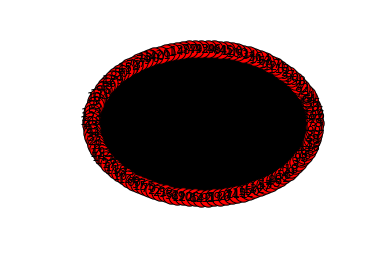

In [35]:
drawGraph(G)

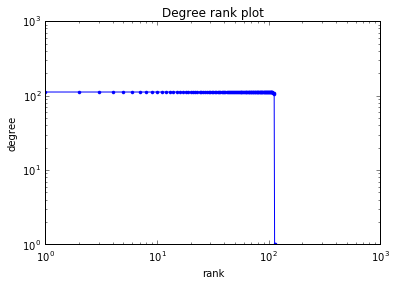

In [36]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence

plt.loglog(degree_sequence,'b-',marker='.')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

In [37]:
print(sorted(nx.degree(G).values())[-20:])

[112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112]


In [38]:
print("Clustering: %0.5f" % nx.average_clustering(G))

Clustering: 0.98113


In [39]:
print("Transitivity: %0.5f" % nx.transitivity(G))

Transitivity: 0.99849


In [40]:
hairball = nx.subgraph(G, [x for x in nx.connected_components(G)][0])
print(nx.average_shortest_path_length(hairball))

1.0015802781289507


In [43]:
from operator import itemgetter

In [44]:
def nbest_centrality(graph, metric, n=10, attribute="centrality", **kwargs):
    centrality = metric(graph, **kwargs)
    nx.set_node_attributes(graph, attribute, centrality)
    degrees = sorted(centrality.items(), key=itemgetter(1), reverse=True)
    
    for idx, item in enumerate(degrees[0:n]):
        item = (idx+1,) + item
        print("%i. %s: %0.4f" % item)
    
    return degrees

In [45]:
degrees = nbest_centrality(G, nx.degree_centrality, n=15)

1. 43: 0.9825
2. 93: 0.9825
3. 35: 0.9825
4. 78: 0.9825
5. 97: 0.9825
6. 106: 0.9825
7. 26: 0.9825
8. 91: 0.9825
9. 8: 0.9825
10. 16: 0.9825
11. 112: 0.9825
12. 143: 0.9825
13. 70: 0.9825
14. 135: 0.9825
15. 17: 0.9825


In [46]:
degrees = nbest_centrality(G, nx.betweenness_centrality, n=15)

1. 43: 0.0000
2. 93: 0.0000
3. 92: 0.0000
4. 35: 0.0000
5. 78: 0.0000
6. 97: 0.0000
7. 106: 0.0000
8. 28: 0.0000
9. 91: 0.0000
10. 8: 0.0000
11. 16: 0.0000
12. 112: 0.0000
13. 143: 0.0000
14. 70: 0.0000
15. 135: 0.0000


In [53]:
degrees = nbest_centrality(G, nx.eigenvector_centrality, n=15)

1. 43: 0.0942
2. 93: 0.0942
3. 35: 0.0942
4. 78: 0.0942
5. 97: 0.0942
6. 106: 0.0942
7. 116: 0.0942
8. 28: 0.0942
9. 8: 0.0942
10. 16: 0.0942
11. 112: 0.0942
12. 143: 0.0942
13. 118: 0.0942
14. 135: 0.0942
15. 17: 0.0942


In [54]:
degrees = nbest_centrality(G, nx.closeness_centrality, n=15)

1. 43: 0.9825
2. 93: 0.9825
3. 92: 0.9825
4. 35: 0.9825
5. 78: 0.9825
6. 97: 0.9825
7. 106: 0.9825
8. 28: 0.9825
9. 91: 0.9825
10. 8: 0.9825
11. 16: 0.9825
12. 112: 0.9825
13. 143: 0.9825
14. 70: 0.9825
15. 135: 0.9825
